# Introduction

### Background: Will the Real Shas Kattan Please Stand Up

There is an old tradition commonly referenced in the yeshiva community that Masekhet Ketubot is the "Shas Kattan" of Talmud Bavli, that is, it contains ideas that connect to just about every other area of Shas (short for "Shisha Sidrei," all six orders of the Mishnah). The source and force of this idea is the subject of an article by R Tuvia Preschel, found here.

Personally, I have thought that this doesn't really seem to be the case; although Ketubot does indeed have a lot of cases involving civil law and connects to many topics covered in tractates Bava Metzia, Bava Batra, and Shevu'ot, and one encounters the laws of Shabbat and Yom Tov in the first 10 pages, it doesn't contain much from Zera'im, Kodshim or Taharot (or Mo'ed really). There seem to me to be much better candidates for Shas Kattan, such as Pesachim or Nedarim, when one considers all six orders of the Mishnah.

The question is, can one computationally determine which tractate is the real "Shas Kattan"; which tractate of the Talmud Bavli has the most varied references to the rest of Shas (all six orders)?

### Approach 1: Uniqe Tractate Scoring (Using Sefaria Links Count)

For each tractate of Talmud Bavli under considering, we can simply tally up how many other tractates (including Mishnah, Bavli/Yerushalmi, and Tosefta) are cited within that tractate of Talmud, with the possible highest score of 63. Perhaps it would be "more fair" to divide that score by the number of words in the given tractate. 

A slight variation on this simple counting method would be to use a points or "scoring" method, where additional citations from the same tractate improves the score incrementally but by decreasing amounts. For example, if the first page of a tractate quotes from Shabbat, Eruvin, and Pesachim, that's three points, and then the second page quotes Shabbat and Gittin, then it will get one more point for Gittin but only another fraction of a point for the additional Shabbat reference. My thinking is that scoring in such a matter should decrease geometrically: for the second time that tractate is referenced, give 0.5 points, then the third time, give 0.25, etc. (So, for example, if a tractate quotes Berakhot once and Shabbat thrice, it will have a score of 1 + 1.75 = 2.75).

### Approach 2: Balance Between "Six Orders" References (Using Sefaria Links Count) 
There is another possible way of interpreting "shas kattan"-ness, which would refer to how well balanced all of the citations are in terms of being a more fair representation of all of the six orders of the Mishnah. A perfectly 'balanced' tractate will have 1/6 of its references to Zera'im, 1/6 to Mo'ed, etc. (although the six orders themselves are not all the same size or have the same number of tractates, so perhaps it makes sense to adjust for that). If we consider each inter-talmudic reference according to one of the six orders, which tractate is closest to the 'balanced ideal' of 1/6 of its references alloted to each order?

### Approach 3: Diversity of Topics
The Sefaria team has worked very hard on "topic ontology," so that each source in their database of Tanakh and Talmud is tagged according to the topics it discusses. Although some topics are much broader than others (to the point where some topics are even included in larger ones; for example "Egypt" is a topic, but so is "Egyptian slavery," and all the sources belonging to the latter also belong to the former) this still might be a better representation of topic diversity than how many of the 63 tractates are references and what order they are from.

# Step 1: Collect, Select, Sort, and Cleanup the Sefaria Dataset

First, grab Sefaria's entire "links" dataset and collect just the information for Shas (which requires just a teeny drop of cleaning up).

"Shas" here is going to include all four types of mishnaic literature: Mishnah, Tosefta, Talmud Bavli, and Talmud Yerushalmi - and we don't care which one is referenced, but we don't want to count them all more than once. So I'll just collect all those references and note which "tractate" of the 63 tractates they belong to.

Two tiny bits of cleanup are also required:
1. Because Sefaria's dataset only includes links in one direction, we will duplicate those so that every cross-reference is bidirectional (i.e., for every time Ketubot quotes Chullin, that means Chullin also quotes Ketubot)
1. "Ohalot" and "Uktzin" have two different spellings for their Tosefta name (go figure)


In [2]:
import requests
import json, urllib.request
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/Sefaria/Sefaria-Export/master/links/links_by_book_without_commentary.csv'
df = pd.read_csv(url)

In [5]:
BTtractates = [ #checked that this lists accords with Sefaria title transliterations
    "Berakhot", "Shabbat", "Eruvin", "Pesachim", "Yoma", "Sukkah", "Beitzah", "Rosh Hashanah", "Taanit", "Megillah", "Moed Katan", "Chagigah",
    "Yevamot", "Ketubot", "Nedarim", "Nazir", "Sotah", "Gittin", "Kiddushin",
    "Bava Kamma", "Bava Metzia", "Bava Batra", "Sanhedrin", "Makkot", "Shevuot", "Avodah Zarah", "Horayot",
    "Zevachim", "Menachot", "Chullin", "Bekhorot", "Arakhin", "Temurah", "Keritot", "Meilah", "Tamid",
    "Niddah"
]

plainshaslist = [ #this is the names of the 63 masechtos, whether mishnah or other
    'Berakhot', "Peah", 'Demai', "Kilayim", "Sheviit", 'Terumot', "Maasrot", "Maaser Sheni",
    'Challah', 'Orlah', 'Bikkurim', 'Shabbat', 'Eruvin', 'Pesachim', 'Shekalim', 'Yoma', 'Sukkah',
    'Beitzah', 'Rosh Hashanah', 'Taanit', 'Megillah', 'Moed Katan', 'Chagigah', 'Yevamot', 'Ketubot',
    'Nedarim', 'Nazir', 'Sotah', 'Gittin', 'Kiddushin', 'Bava Kamma', 'Bava Metzia', 'Bava Batra',
    'Sanhedrin', 'Makkot', "Shevuot", 'Eduyot', 'Avodah Zarah', 'Pirkei Avot', 'Horayot', 'Zevachim',
    'Menachot', 'Chullin', 'Bekhorot', 'Arakhin', 'Temurah', 'Keritot', "Meilah", 'Tamid', 'Middot',
    'Kinnim', 'Keilim', 'Kelim', 'Ohalot', 'Oholot', "Negaim", 'Parah', 'Tahorot', "Mikvaot", 'Niddah', 'Makhshirin',
    'Zavim', 'Tevul Yom', 'Yadayim', 'Oktzin', 'Oktsin' #yes there are two Ohalot's and two Oktzin's which we will have to merge later
]

In [6]:
shaslist = []

#Allowing for references to Mishnah, Tosefta, and Jerusalem Talmud
for n in plainshaslist:
    mish = "Mishnah " + n
    tos = "Tosefta " + n #We are actaully going to be missing Tosefta Keilim Kama, etc. but I think that's ok
    jeru = "Jerusalem Talmud " + n
    nlist = [mish, tos, jeru, n]
    shaslist += nlist

In [7]:
# Collect only cross-references of Shas, not commentaries, Tanakh, etc.
filtered1_df = df[df['Text 1'].isin(BTtractates)]
filtered2_df = filtered1_df[filtered1_df['Text 2'].isin(shaslist)]

# Add reverse cross-references (i.e. if Berakhot quotes Shabbat 54 times, make sure that
    # the number 54 is reflected both in 'Berakhot > Shabbat' and in 'Shabbat > Berakhot')
# Create an empty DataFrame to collect new rows that need to be added
new_rows = []

# Iterate through the DataFrame to find rows to reverse
for index, row in filtered2_df.iterrows():
    if row['Text 2'] in BTtractates:
        # Create a new row with "Text 1" and "Text 2" reversed, while keeping "Tractate" and "Link Count" the same
        new_row = pd.DataFrame({
            'Text 1': [row['Text 2']],
            'Text 2': [row['Text 1']],
            'Link Count': [row['Link Count']]
        })
        new_rows.append(new_row)

# Concatenate the new rows with the original DataFrame
df_augmented = pd.concat([filtered2_df] + new_rows, ignore_index=True)

# create a sorting scheme
df_sort = df_augmented.copy()  # Making a copy to avoid affecting the original df
df_sort['Text 1'] = pd.Categorical(df_sort['Text 1'], categories=BTtractates, ordered=True)
sorted_df = df_sort.sort_values('Text 1')

crossrefs = sorted_df #making another copy

# Convert "Text 2" to a categorical type with categories in the specified order of shaslist
crossrefs['Text 2'] = pd.Categorical(crossrefs['Text 2'], categories=shaslist, ordered=True)

# Now sort the DataFrame first by "Text 1" and then by "Text 2"
crossrefs_sorted = crossrefs.sort_values(['Text 1', 'Text 2'])
crossrefs_sorted

,Text 1,Text 2,Link Count
54,Berakhot,Mishnah Berakhot,85
21,Berakhot,Tosefta Berakhot,149
1,Berakhot,Jerusalem Talmud Berakhot,260
2461,Berakhot,Berakhot,85
53,Berakhot,Berakhot,85
...,...,...,...
64,Niddah,Tosefta Niddah,76
2464,Niddah,Niddah,81
60,Niddah,Niddah,81
1610,Niddah,Tosefta Zavim,2


In [8]:
# Now let's find the greatest number of links for each "tractate," including Mishnah/Tosefta/Yerushalmi/Bavli

crossrefs_copy = crossrefs_sorted #copying again just in case

#We have to fix "Oktzin" and "Ohalot":
crossrefs_copy = crossrefs_copy.replace(to_replace='Oktsin', value='Oktzin', regex=True)
crossrefs_copy = crossrefs_copy.replace(to_replace='Oholot', value='Ohalot', regex=True)

# Function to collapse all the different types of "Tractates" by removing prefixes
def remove_prefixes(text):
    # Define prefixes to remove
    prefixes = ["Mishnah ", "Tosefta ", "Jerusalem Talmud "]
    for prefix in prefixes:
        if text.startswith(prefix):
            return text[len(prefix):]  # Remove the prefix and return
    return text  # Return the original text if no prefix matched

# Create a new "Tractate" column that will apply the function
crossrefs_copy['Tractate'] = crossrefs_copy['Text 2'].apply(remove_prefixes)

#Re-sort
# create a sorting scheme
df_sort = crossrefs_copy.copy()  # Making a copy to avoid affecting the original df
df_sort['Text 1'] = pd.Categorical(df_sort['Text 1'], categories=BTtractates, ordered=True)
sorted_df = df_sort.sort_values('Text 1')
sorted_df['Text 2'] = pd.Categorical(sorted_df['Text 2'], categories=shaslist, ordered=True)

# Now sort the DataFrame first by "Text 1" and then by "Text 2"
crossrefs_copy_sorted = crossrefs_copy.sort_values(['Text 1', 'Text 2'])

# reset index values to go in order
crossrefs_copy_sorted = crossrefs_copy_sorted.reset_index(drop=True)

In [9]:
crossrefs_copy_sorted.to_csv('all-references.csv', sep=',')


#If you want to view the entire dataframe, convert this block to code:

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(crossrefs_copy_sorted)

# Approach 1: Count the Number of Cross-References

We can't just sum up all the references to Mishnah, Tosefta, Talmud Yerushalmi and Bavli, because many of those will be duplicates (for example, a link might exist to a Mishnah which also appears in the Tosefta and Talmuds, and give a score of 4, when really it should just be counted as 1). So we'll just count the *greatest* numerical value from among any of the possible references within a single tractate. And another small bit of cleaning up to remove self-referenes (Berakhot to Berakhot, whether Tosefta, Mishnah, etc.)

In [10]:
# Remove all rows where 'Text 1' is 'Text 2'
crossrefs_copy_sorted['Text 1'] = crossrefs_copy_sorted['Text 1'].astype(str) #bit of a roundabout way but otherwise python doesn't recognize the values as identical
crossrefs_copy_sorted['Text 2'] = crossrefs_copy_sorted['Text 2'].astype(str)
crossrefs_copy_sorted = crossrefs_copy_sorted[crossrefs_copy_sorted['Text 1'] != crossrefs_copy_sorted['Text 2']]

In [11]:
# Create a new dataset for "Link Count values"
# Initialize an empty dictionary to hold the maximum "Link Count" for each unique pair of "Text 1" and "Tractate"
max_link_dict = {}

# Iterate over each row in the DataFrame to populate the dictionary
for _, row in crossrefs_copy_sorted.iterrows():
    key = (row['Text 1'], row['Tractate'])  # Unique key is a tuple of "Text 1" and "Tractate"
    link_count = row['Link Count']
    text2 = row['Text 2']

    # If the key is not in the dictionary or the current row's "Link Count" is greater than the stored value, update the dictionary
    if key not in max_link_dict or link_count > max_link_dict[key]['Link Count']:
        max_link_dict[key] = {'Text 2': text2, 'Link Count': link_count}

# Convert the dictionary back to a DataFrame for easy viewing and manipulation
max_link_df = pd.DataFrame([(*key, value['Text 2'], value['Link Count']) for key, value in max_link_dict.items()], columns=['Text 1', 'Tractate', 'Text 2', 'Link Count'])

# Now again remove all rows where 'Text 1' is equivalent to 'Tractate'
max_link_df['Text 1'] = max_link_df['Text 1'].astype(str)
max_link_df['Tractate'] = max_link_df['Tractate'].astype(str)
max_link_df = max_link_df[max_link_df['Text 1'] != max_link_df['Tractate']]

In [12]:
# Create another new dataset named 'score' to count the number of unique 'Tractate' values associated with each 'Text 1' value

# Group the DataFrame by 'Text 1' and then count the number of unique 'Tractate' values for each group
score = max_link_df.groupby('Text 1')['Tractate'].nunique().reset_index()

# Rename columns for clarity
score.columns = ['Text 1', 'Unique Tractate Count']

score_sorted = score.sort_values(by='Unique Tractate Count', ascending=False)

# reset index values to go in order
score_sorted = score_sorted.reset_index(drop=True)

 In theory, I believe would be the most accurate reflection of 'shas-kattan-ness' would be to score each tractate's references as follows: give one point for every unique Tractate referenced. For the second time that tractate is referenced, give 0.5 points, then the third time, give 0.25, etc. (So, for example, if a tractate quotes Berakhot once and Shabbat thrice, it will have a score of 1 + 1.75 = 2.75). Below we score the cross-references in such a way, but perhaps a more exponential discounting would be better, I dunno

In [13]:
#Now for a more complicated scoring technique using a geometrically decreasing for each additional link per tractate
data = max_link_df

# Calculate the "Link Count Score" for each row
data['Link Count Score'] = data['Link Count'].apply(lambda n: (1 - (0.5 ** n)) / (1 - 0.5))

# Group by "Text 1" and sum the "Link Count Score" for each group
final_scores = data.groupby('Text 1')['Link Count Score'].sum().reset_index()

# Now combine them all and view the dataset
combined_df = pd.merge(score_sorted, final_scores, left_on='Text 1', right_on='Text 1', how='left')

# Also renaming columns to something understandable
combined_df.rename(columns={'Text 1': 'Tractate', 'Unique Tractate Count': 'Unique Tractates Referenced', 'Link Count Score': 'Exponential-Decrease-Score'}, inplace=True)
combined_df

,Tractate,Unique Tractates Referenced,Exponential-Decrease-Score
0,Chullin,62,116.895779
1,Menachot,58,104.109858
2,Eruvin,58,104.119613
3,Berakhot,56,101.774769
4,Gittin,55,99.061363
5,Avodah Zarah,55,93.154013
6,Bekhorot,55,95.355213
7,Bava Metzia,54,96.763626
8,Pesachim,53,98.128240
9,Niddah,52,91.598348


### (Aborted) Normalization Efforts
Maybe it would be more fair to correct for how big the tractate is, such as by how many words it has? In the end I don't think this is actually informative, because tractates differ from each other so much more by word count than by cross-reference count. Maybe page number is more fair, but tractates also differ significantly by how many words there are on each page, so... yeah.

In [14]:
#Check Link Number/Score with other Talmud stats

# import talmud stats from "the internet" as dict
data = {
    "words/daf": [1115.14, 975.11, 971.69, 933.52, 931.76, 889.70, 805.50, 815.60, 751.97, 765.57, 729.62, 731.56, 712.81, 715.04, 711.64, 691.35, 698.94, 696.08, 698.23, 687.53, 686.13, 683.51, 676.45, 681.60, 671.59, 661.24, 657.24, 646.52, 638.92, 635.14, 587.31, 582.73, 512.22, 508.82, 430.52, 384.00, 383.06],
    "letters/daf": [4337.46, 3786.44, 3771.92, 3718.42, 3625.12, 3536.23, 3204.36, 3179.48, 2972.61, 2947.04, 2866.87, 2859.64, 2827.15, 2800.14, 2782.31, 2762.51, 2760.97, 2738.49, 2729.91, 2724.15, 2704.34, 2684.79, 2668.62, 2660.13, 2648.57, 2602.73, 2592.09, 2540.40, 2507.10, 2494.26, 2323.16, 2299.84, 2049.89, 1978.57, 1670.32, 1535.95, 1499.28],
    "words": [70254, 26328, 12632, 28939, 104357, 26691, 22554, 39149, 24815, 17608, 113820, 59256, 18533, 84375, 83973, 51851, 23065, 50118, 84486, 23376, 82335, 60832, 40587, 32717, 73203, 73398, 57180, 67238, 24918, 89555, 32302, 69345, 4610, 89044, 27984, 8064, 34475],
    "letters": [273260, 102234, 49035, 115271, 406013, 106087, 89722, 152615, 98096, 67782, 447232, 231631, 73506, 330417, 328313, 207188, 91112, 197171, 330319, 92621, 324521, 238946, 160117, 127686, 288694, 288903, 225512, 264202, 97777, 351691, 127774, 273681, 18449, 346249, 108571, 32255, 134935],
    "daf": [63, 27, 13, 31, 112, 30, 28, 48, 33, 23, 156, 81, 26, 118, 118, 75, 33, 72, 121, 34, 120, 89, 60, 48, 109, 111, 87, 104, 39, 141, 55, 119, 9, 175, 65, 21, 90],
    "mesechta": ["Berakhot", "Keritot", "Horayot", "Megillah", "Sanhedrin", "Taanit", "Moed Katan", "Sotah", "Arakhin", "Makkot", "Shabbat", "Kiddushin", "Chagigah", "Bava Metzia", "Bava Kamma", "Avodah Zarah", "Temurah", "Niddah", "Yevamot", "Rosh Hashanah", "Pesachim", "Gittin", "Bekhorot", "Shevuot", "Menachot", "Ketubot", "Yoma", "Eruvin", "Beitzah", "Chullin", "Sukkah", "Zevachim", "Tamid", "Bava Batra", "Nazir", "Meilah", "Nedarim"]
}

# Convert to DataFrame
df_mesechta = pd.DataFrame(data)


In [15]:
# Merge to include 'pages' from 'df_mesechta'
combined_df = pd.merge(combined_df, df_mesechta[['mesechta', 'daf']], left_on='Tractate', right_on='mesechta', how='left')

# Divide score by number of daf
combined_df['Normalized to Page Number'] = combined_df['Exponential-Decrease-Score'] / combined_df['daf']

In [16]:
# Select only the relevant columns
final = combined_df[['Tractate', 'Unique Tractates Referenced', 'Exponential-Decrease-Score', 'Normalized to Page Number']]
final_sorted = final.sort_values(by='Normalized to Page Number', ascending=False)

### Make pretty pictures

In [17]:
df = combined_df[['Tractate', 'Unique Tractates Referenced', 'Exponential-Decrease-Score']]
df = df.sort_values(by=['Unique Tractates Referenced', 'Exponential-Decrease-Score'], ascending=False)

In [21]:
!pip install networkx

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 1.3 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 2.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.7 MB 3.7 MB/s eta 0:00:01
   -------------------------- ------------- 1.1/1.7 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 6.4 MB/s eta 0:00:00


In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# Renaming columns according to chord diagram convention
df.columns = ['Source', 'Target', 'Value']

# Define the sedarim and their tractates for color-coding the nodes
sedarim = {
    'Zeraim': ['Berakhot', "Peah", 'Demai', "Kilayim", "Sheviit", 'Terumot', "Maasrot", "Maaser Sheni", "Challah", 'Orlah', 'Bikkurim'],
    'Moed': ['Shabbat', 'Eruvin', 'Pesachim', 'Shekalim', 'Yoma', 'Sukkah','Beitzah', 'Rosh Hashanah', 'Taanit', 'Megillah', 'Moed Katan', 'Chagigah'],
    'Nashim': ['Yevamot', 'Ketubot','Nedarim', 'Nazir', 'Sotah', 'Gittin', 'Kiddushin'],
    'Nezikin': ['Bava Kamma', 'Bava Metzia', 'Bava Batra','Sanhedrin', 'Makkot', "Shevuot", 'Eduyot', 'Avodah Zarah', 'Pirkei Avot', 'Horayot'],
    'Kodshim': ['Zevachim', 'Menachot', 'Chullin', 'Bekhorot', 'Arakhin', 'Temurah', 'Keritot', "Meilah", 'Tamid', 'Middot','Kinnim'],
    'Taharot': ['Keilim', 'Kelim', 'Ohalot', 'Oholot', "Negaim", 'Parah', 'Tahorot', "Mikvaot", 'Niddah', 'Makhshirin', 'Zavim', 'Tevul Yom', 'Yadayim', 'Oktzin', 'Oktsin']
}

# Map each tractate to its Seder
tractate_to_seder = {tractate: seder for seder, tractates in sedarim.items() for tractate in tractates}

# Define a color map for each of the sedarim
seder_colors = {
    'Zeraim': 'red',
    'Moed': 'blue',
    'Nashim': 'green',
    'Nezikin': 'yellow',
    'Kodshim': 'purple',
    'Taharot': 'orange'
}
# Create a graph from the dataframe
G = nx.from_pandas_edgelist(df, 'Source', 'Target', ['Value'])

# Transfer the color list to nodes
default_color = 'grey' # just in case there's something not in the list (i.e. misspelled, etc), I'll find it
node_colors = [seder_colors.get(tractate_to_seder.get(node, None), default_color) for node in G.nodes()]

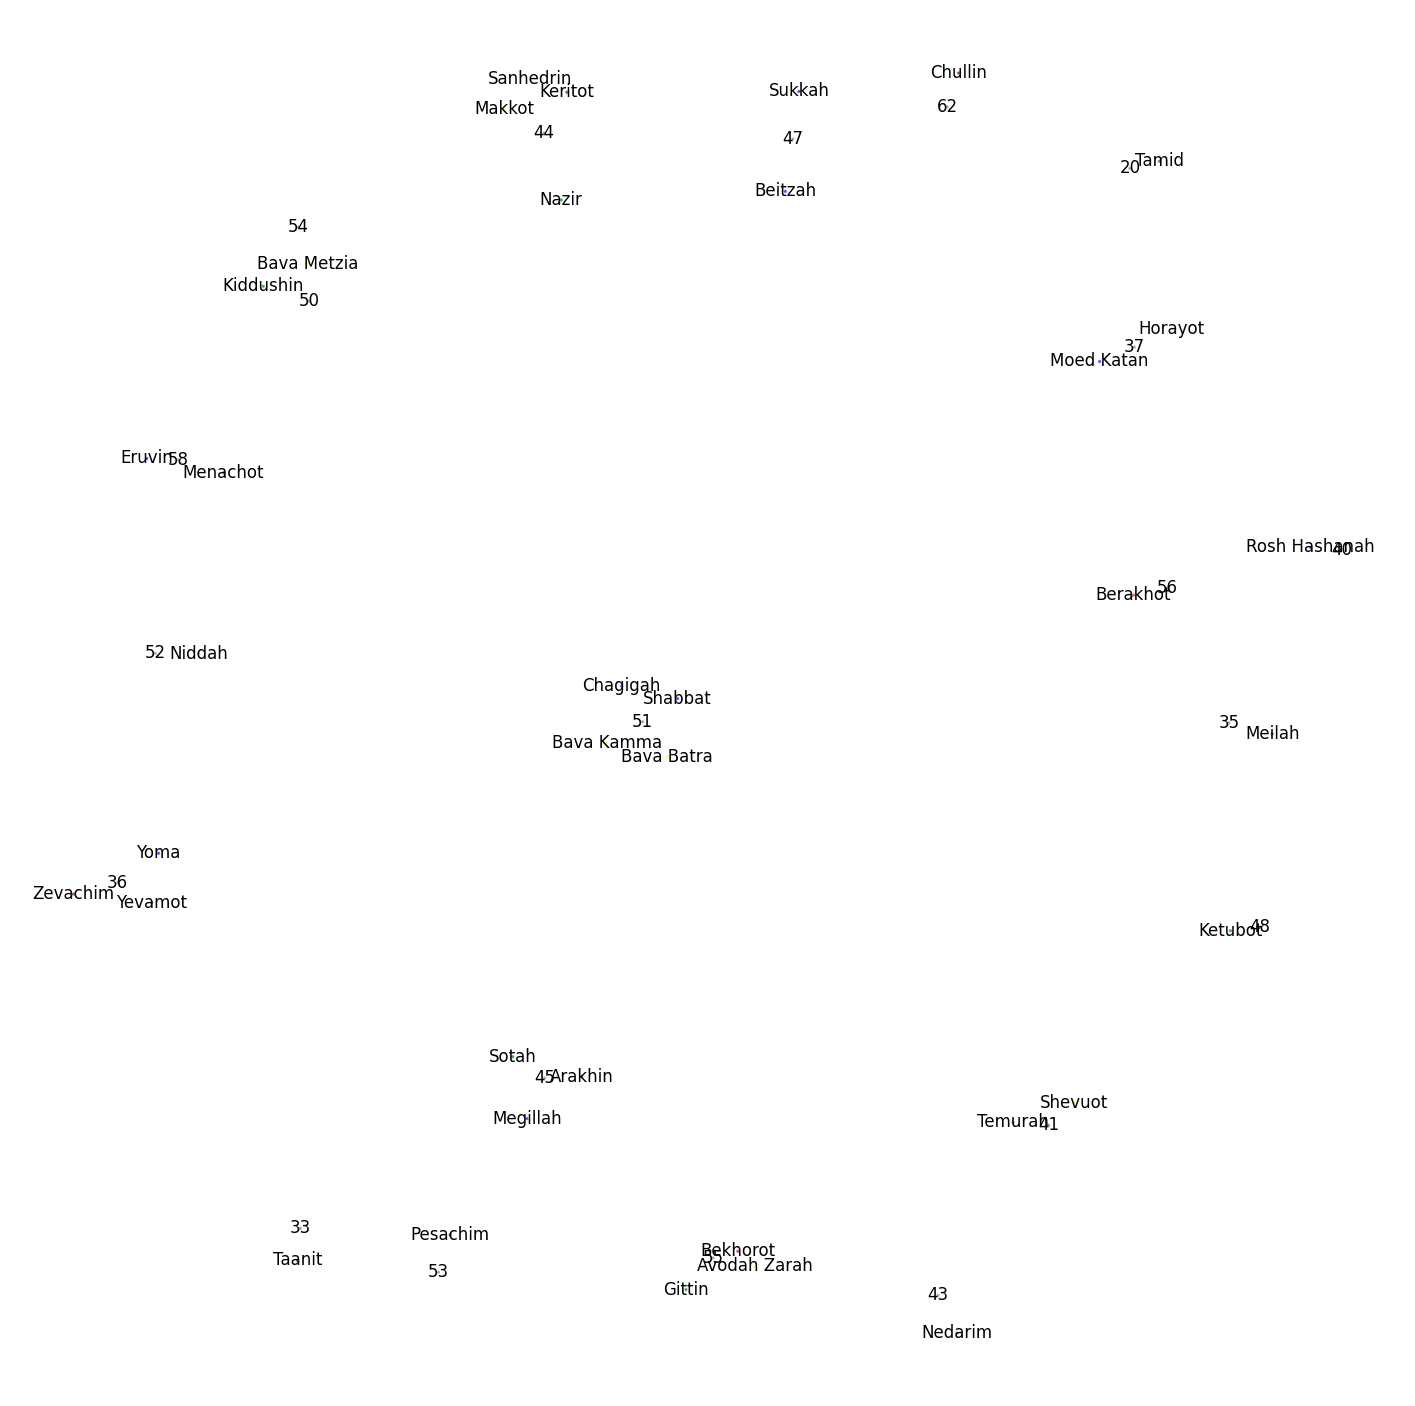

In [29]:
# Draw the network
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw_networkx_nodes(G, pos, node_size=2, node_color=node_colors, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12)
#edges = nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.show()

# Approach 2: Balance Between "Six Orders"

# Approach 3: Using Sefaria's "Topics" Ontology Tool

In [ ]:
#downlaod the giant index list
import requests

url = "https://www.sefaria.org/api/index/"
response = requests.get(url)
data = response.json()

# A roundabout way of collecting all the titles of the Talmud Bavli, according to Sefaria's 
# Requires a few levels of parsing the json object 
data_list = list(data) 
fullmetadict = dict(data_list[2])
fulldict = fullmetadict['contents']
fulldict = fulldict[0] #this contains all of the "Talmud" corpus

whatlist = []

#now I'll collect the next level down (which includes Zera'im, Mo'ed, but also Commentaries, etc.)
for k,v in fulldict.items():
    if k == 'contents':
        for i in v:
            for new_i in v:
                whatlist.append(new_i)

bavli_titles = []

# Now I can collect only the Talmud Bavli titles, which are contained in the first 6 Talmud categories
for i in whatlist[:6]:
    sederdict = i
    for v in sederdict['contents']:
        bavli_titles.append(v['title'])

In [ ]:
# Function for using the Talmud Bavli name to get all the related topics
def get_topics_for_book(book_name):
    # Build the text reference
    text_ref = f"{book_name}"

    # Endpoint URL for getting topics associated with a text
    url = f"https://www.sefaria.org/api/related/{text_ref}"

    # Make the GET request
    response = requests.get(url, timeout = 600)
    if response.status_code == 200: #error handling
        topics = response.json()
        return topics
    else:
        return f"Failed to retrieve topics: Status Code {response.status_code}"

In [ ]:
# This will collect a names of all the unique topics associated with each tractate
bavli_topics_lists = {}
bavli_topics_num = {} #and this will keep the count

for book in bavli_titles:
    try:
        links = get_topics_for_book(book) #See function
    
        topicsdetails = links['topics'] # Parse json by collecting the topics 

        # Make a list of each topic that is connected to this book...
        topicnames = []

        # By parsing through the dictionary object of all the topics 
        for i in topicsdetails:
            topicnames.append(i['topic']) #and just collect the actual name of the topic
    
        #remove duplicates from the topic list
        topicnames = list(set(topicnames))

        # Assign the topic list, and its length, to dictionaries with the tractate name as the key
        bavli_topics_lists[book] = topicnames 
        bavli_topics_num[book] = len(topicnames)
        #print('successfully analyzed {book}!')

    except:
        print(f'failed to collect data for {book})

In [ ]:
# Now let's see which tractates have the most associated topics 
# Convert the dictionary into a dataframe
topicsdf = pd.DataFrame([(key, value) for key, value in bavli_topics_num.items()], columns=['Tractate', 'Topics Count'])

# create a sorting scheme
topicsdf = topicsdf.sort_values('Topics Count', ascending=False)
topicsdf